# Model clinical trajectories from longitudinal data
* **Input:** 
    1. Clinical data - csv / tables    


* **functions**
    1. Generate trajectory templates
    2. Assign trajectory labels to new subjects


* **user parameters**
    1. Number of timepoints for modeling
    2. Number of clusters (post-hoc) 

In [1]:
# Basic lib imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.spatial.distance import pdist
%matplotlib inline

In [135]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import euclidean_distances

def define_clusters(df,feat_cols,n_clusters, plot_clusters, permute):
    # Returns orginal dataframe with cluster assignments
    # Returns percentage overlap of clusters for each permuted sample
    
    if plot_clusters:
        g = sns.clustermap(df[feat_cols], row_cluster=True, col_cluster=False, metric = 'euclidean', method='ward', 
                           xticklabels=True, yticklabels=False)    
        
    Z = sch.linkage(pdist(df[feat_cols]), metric ='euclidean',method='ward')
    #Z2 = g.dendrogram_row.linkage #same as above but from sns.clustermap handle
    
    T = sch.fcluster(Z, n_clusters, 'maxclust')      
    df['T'] = T
        
    # mean trajectory templates 
    traj_templates = {}
    for traj in range(1,n_clusters+1):
        traj_templates[traj] = np.round(np.mean(df[df['T']==traj][feat_cols].values,axis=0),3)
            
    #Stability 
    if permute:    
        permute_ci = compute_stability(df,feat_cols,n_clusters,permute)
    else:
        permute_ci = False
            
    return df, traj_templates, permute_ci

# Compute stability of cluster based on overlap of subjects that belong to same cluster during permutations
def compute_stability(_df,feat_cols,n_clusters, permute):
    permute_ci = [] #summary stat computed over all clusters for all permutations
    for p in range(permute):                     
        # Create two samples
        df_samp_1 = _df.sample(frac=0.8)            
        df_samp_2 = _df.sample(frac=0.8)     
        sub_samp_1 = df_samp_1['sub'].values
        sub_samp_2 = df_samp_2['sub'].values            

        # Generate two permuted solutions
        Z_samp = sch.linkage(pdist(df_samp_1[feat_cols]), metric ='euclidean',method='ward')
        T_samp_1 = sch.fcluster(Z_samp, n_clusters, 'maxclust')      
        Z_samp = sch.linkage(pdist(df_samp_2[feat_cols]), metric ='euclidean',method='ward')            
        T_samp_2 = sch.fcluster(Z_samp, n_clusters, 'maxclust')      

        #Find overlap between subjects that belong to same cluster
        cluster_intersect = [] #list of all cluster intersections during permutation
        for c1 in range(1,n_clusters+1):
            ci = [] # cluster intersection within a single permutation
            for c2 in range(1,n_clusters+1): #Compare with every cluster from second permuted sample
                ci.append(len(set(sub_samp_1[T_samp_1==c1])&set(sub_samp_2[T_samp_2==c2])))

            #Since cluster number/name have no particular order, 
            # we are looking for maximum overlap between each cluster solution
            cluster_intersect.append(np.max(ci))

        # Fraction of subjects maintained their cluster membership in a permuted sample
        permute_ci.append(np.sum(cluster_intersect)/len(df_samp_1))
        
    return permute_ci

# TODO
# Assign cluster membership to a new subject based on proximity to available cluster templates
def assign_clusters(_df,feat_cols,traj_templates):
    assert len(feat_cols) == len(traj_templates[1]) 
    subject_scores = _df[feat_cols].values
    
    # Maintain order of template names (A,B,C...)
    traj_names = np.tile(np.array(list(traj_templates.keys())),(len(subject_scores),1))
    #print(traj_names)
    traj_vals = np.array(list(traj_templates.values()))
    dst = euclidean_distances(subject_scores,traj_vals) #pairwise distances from each subject to each template
    _df['prox_vec'] = list(np.round(dst/np.sum(dst,1)[:,None],3))
    _df['T'] = traj_names[np.arange(len(traj_names)),np.argmin(dst,axis=1)] #the closest templates        
    
    return _df


# Play with number of clusters -> check stability 

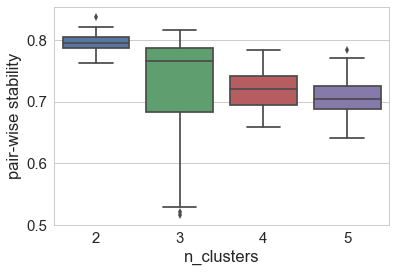

In [136]:
#simulated data
n_subs = 100
n_feat = 10
a = np.random.rand(n_subs,n_feat)
b = 2*np.random.rand(n_subs,n_feat)
c = 4*np.random.rand(n_subs,n_feat)
d = np.vstack((a,b,c))
df = pd.DataFrame(data=d)

df['sub'] = range(len(df))
feat_cols = list(range(n_feat))

plot_clusters = False # To avoid messy plots, only plot when you have a single n_clusters value (see below)
permute = 100

# Iterate through different cluster solutions
cluster_list = [2,3,4,5]
stab = np.zeros((len(cluster_list),permute))
for n,n_clusters in enumerate(cluster_list):
    df,traj_templates, permute_ci = define_clusters(df,feat_cols,n_clusters,plot_clusters,permute)
    stab[n,:] = permute_ci

# Plot cluster stability
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g2 = sns.boxplot(data=pd.DataFrame(stab.T,columns=cluster_list),orient='v')
    plt.xlabel('n_clusters')
    plt.ylabel('pair-wise stability')

# Pick a cluster solution (n_cluster)

Mean values per cluster, i.e. trajectory templates
{1: array([2.024, 1.995, 1.926, 2.057, 2.148, 2.029, 1.886, 2.14 , 2.219,
       1.891]), 2: array([0.547, 0.525, 0.504, 0.548, 0.47 , 0.491, 0.48 , 0.494, 0.527,
       0.473]), 3: array([0.965, 1.075, 1.098, 1.159, 1.03 , 1.107, 1.034, 0.931, 0.954,
       1.058])}


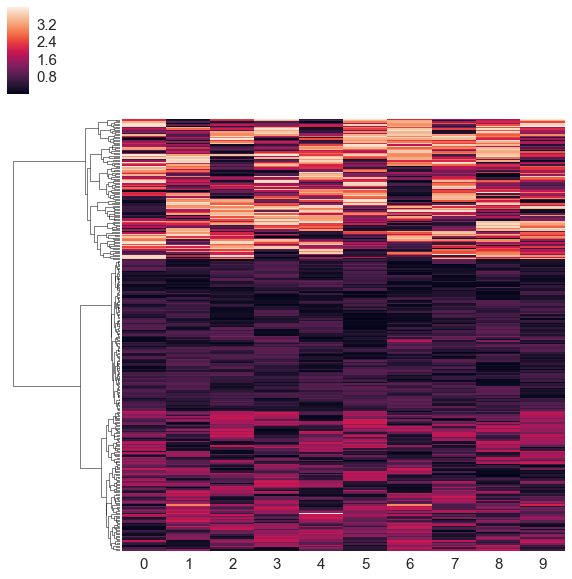

In [137]:
# Pick a cluster solution (n_cluster)
n_clusters = 3
permute = False # No need to permute now 
plot_clusters = True
df,traj_templates, permute_ci = define_clusters(df,feat_cols,n_clusters,plot_clusters,permute)

print('Mean values per cluster, i.e. trajectory templates')
print(traj_templates)

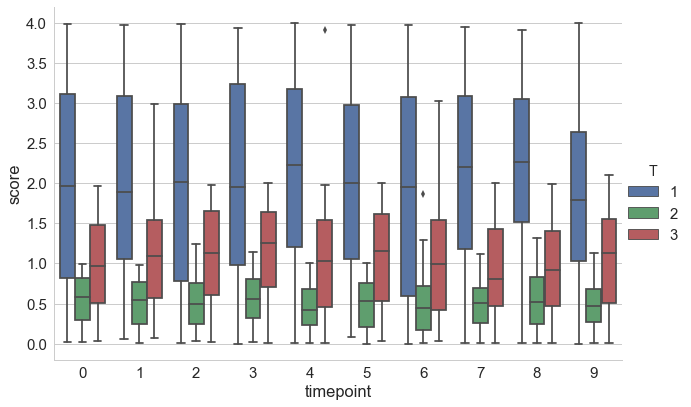

In [138]:
# Plot: trajectory score distributions 
traj_df = pd.melt(df, id_vars=['sub','T'],value_vars=feat_cols,var_name='timepoint',value_name='score')
with sns.axes_style("whitegrid"):
    g1 = sns.factorplot(y='score',x='timepoint',hue='T',data=traj_df, kind='box',size=6,aspect=1.5)
#     g1.set_xticklabels(rotation=30)

# Assign cluster to new set of subjects

In [139]:
# Sim data (from same distribution as before)
n_subs = 10
a = np.random.rand(n_subs,n_feat)
b = 2*np.random.rand(n_subs,n_feat)
c = 4*np.random.rand(n_subs,n_feat)
d = np.vstack((a,b,c))
df = pd.DataFrame(data=d)

df['sub'] = range(len(df))
feat_cols = list(range(n_feat))

# Assign based on Euclidean proximity (need to be consistent wit)
df = assign_clusters(df,feat_cols,traj_templates)
df

,0,1,2,3,4,5,6,7,8,9,sub,prox_vec,T
0,0.796248,0.868252,0.709680,0.586499,0.329172,0.758323,0.132734,0.592526,0.944576,0.917357,0,"[0.651, 0.134, 0.215]",2
1,0.404738,0.062597,0.994000,0.044913,0.655559,0.188248,0.514502,0.897766,0.557962,0.699091,1,"[0.617, 0.129, 0.254]",2
2,0.360124,0.164621,0.468032,0.902318,0.814143,0.512964,0.600693,0.516110,0.686026,0.507026,2,"[0.668, 0.095, 0.237]",2
3,0.760422,0.784406,0.408454,0.628816,0.702404,0.935192,0.001945,0.288230,0.692480,0.275857,3,"[0.644, 0.115, 0.241]",2
4,0.779135,0.129347,0.556713,0.869840,0.301753,0.033743,0.675893,0.840116,0.379705,0.044088,4,"[0.622, 0.118, 0.26]",2
5,0.530968,0.684597,0.225615,0.928877,0.049371,0.665566,0.679763,0.218221,0.304868,0.304767,5,"[0.645, 0.103, 0.252]",2
6,0.800937,0.216567,0.933397,0.120331,0.486128,0.363825,0.017950,0.420183,0.175711,0.132559,6,"[0.616, 0.115, 0.269]",2
7,0.064380,0.798379,0.157184,0.230097,0.585351,0.663219,0.694481,0.588304,0.813794,0.927666,7,"[0.632, 0.127, 0.241]",2
8,0.660049,0.705529,0.488990,0.999533,0.893078,0.103462,0.744464,0.927816,0.222136,0.993019,8,"[0.629, 0.156, 0.215]",2
9,0.369787,0.863513,0.832357,0.604759,0.831453,0.285131,0.140673,0.156215,0.123881,0.869282,9,"[0.631, 0.126, 0.242]",2
